In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.spatial import distance
import xml.etree.ElementTree as ET
from shapely.geometry import Polygon, LineString
import pandas as pd
#from src.generate_traffic_data import clean_carla, spawn_scene, run_scene
import carla
import os
os.getcwd()
from datetime import datetime
import time
import random
from tqdm import tqdm
import networkx as nx
import numpy as np
import pickle
from graph_creator.MapGraph import MapGraph
from graph_creator.utilities import make_node_edge_df
from graph_creator.SubgraphIsomorphismChecker import IsomorphicGrapCoverageCounter
from graph_creator.ActorGraph import ActorType

os.chdir('../..')
print(os.getcwd())

#from graph_creator.MapGraph import MapGraph
#from graph_creator.ActorGraph import ActorGraph

from graph_creator.plot_graphs import plot_lane_map_advanced, add_actors_to_map, add_actor_edges_to_map

from glob import glob
import pickle
import networkx as nx
import random
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

graph_paths_carla = glob("/home/tmuehlen/repos/graph_coverage/actor_graphs/carla_w_intersection/*pkl")
len(graph_paths_carla)

/home/tmuehlen/repos/graph_coverage


14099

In [7]:
graph_paths_argo = glob("/home/tmuehlen/repos/graph_coverage/actor_graphs/argoverse_components_nx/*pkl")
graph_paths_argo = glob("/home/tmuehlen/repos/graph_coverage/actor_graphs/argoverse_components_nx/*pkl")

len(graph_paths_argo)

14726

### Start comparing graphs by randomly picking some:

In [8]:
# Define a random set of coverage situations with 3 nodes each
# This still needs to be replaced by more strategically selected graphs

#idxs = [100, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000]
idxs = random.sample(list(range(len(graph_paths_carla))), 10)

coverage_graphs = {}
cov_data = {}

for idx in idxs:
    graph_path = graph_paths_carla[idx]
    with open(graph_path, "rb") as file:
        ag_nx = pickle.load(file)
    #random.sample(ag_nx.nodes, 3)
    if ag_nx.number_of_nodes() > 2:
        coverage_graphs[idx] = ag_nx.subgraph(random.sample(list(ag_nx.nodes), 3))
        # cov_data[idx] = []

#cov_data["degree"] = []
#cov_data["density"] = []#
# cov_data["diameter"] = []


In [9]:
isom_cov_counter = IsomorphicGrapCoverageCounter(coverage_graphs, graph_paths_carla[:100], node_match = ["actor_type", "lane_change", "is_on_intersection"], edge_match = ["edge_type"])
isom_cov_counter.count_isomorphic_graphs()
cov_data_df = isom_cov_counter.cov_data_df

100%|██████████| 100/100 [00:00<00:00, 608.09it/s]


In [10]:
cov_data_df.head(2)

,6177,13686,1424,956,degree,density,diameter,path
0,False,False,False,False,2.0,1.0,1,/home/tmuehlen/repos/graph_coverage/actor_grap...
1,False,False,False,False,2.0,1.0,1,/home/tmuehlen/repos/graph_coverage/actor_grap...


In [11]:
cov_data_df.mean(numeric_only=True)


6177        0.090000
13686       0.230000
1424        0.300000
956         0.230000
degree      2.757233
density     0.803521
diameter    1.820000
dtype: float64

In [12]:
cov_data_df.groupby(list(cov_data_df.columns[:(cov_data_df.shape[1] - 3)]), as_index=False).size()


,6177,13686,1424,956,degree,size
0,False,False,False,False,2.000000,55
1,False,False,False,False,2.666667,7
2,False,False,False,False,4.000000,4
3,False,False,True,False,2.666667,9
4,False,False,True,False,4.000000,1
5,False,True,True,True,3.000000,3
6,False,True,True,True,3.200000,1
7,False,True,True,True,3.333333,2
8,False,True,True,True,4.000000,3
9,False,True,True,True,4.444444,1


In [13]:
coverage_graphs

{6177: <networkx.classes.multidigraph.MultiDiGraph at 0x714f4037e650>,
 13686: <networkx.classes.multidigraph.MultiDiGraph at 0x714f4037e7a0>,
 1424: <networkx.classes.multidigraph.MultiDiGraph at 0x714e6ba1db40>,
 956: <networkx.classes.multidigraph.MultiDiGraph at 0x714e6ba1d690>}

### define some situations manually

In [14]:
coverage_graphs = {}

In [15]:
G = nx.MultiDiGraph()
G.add_node("a", actor_type=ActorType.VEHICLE, lane_change=False, is_on_intersection=False)
G.add_node("b", actor_type=ActorType.VEHICLE, lane_change=False, is_on_intersection=False)
G.add_node("c", actor_type=ActorType.VEHICLE, lane_change=False, is_on_intersection=False)
G.add_edge("a", "b", edge_type="following_lead")
G.add_edge("b", "a", edge_type="following_lead")
G.add_edge("a", "c", edge_type="neighbor_vehicle")
G.add_edge("c", "a", edge_type="neighbor_vehicle")
G.edges(data=True)
coverage_graphs["lead_vehicle_in_front_with_neighbor_vehicle"] = G

In [16]:
G = nx.MultiDiGraph()
G.add_node("a", actor_type=ActorType.VEHICLE, lane_change=False, is_on_intersection=True)
G.add_node("b", actor_type=ActorType.VEHICLE, lane_change=False, is_on_intersection=False)
G.add_node("c", actor_type=ActorType.VEHICLE, lane_change=False, is_on_intersection=True)
G.add_edge("a", "b", edge_type="following_lead")
G.add_edge("b", "a", edge_type="following_lead")
G.add_edge("a", "c", edge_type="neighbor_vehicle")
G.add_edge("c", "a", edge_type="neighbor_vehicle")
G.edges(data=True)
coverage_graphs["lead_vehicle_in_front_with_neighbor_vehicle_intersection"] = G

In [17]:
G = nx.MultiDiGraph()
G.add_node("a", actor_type=ActorType.VEHICLE, lane_change=False, is_on_intersection=False)
G.add_node("b", actor_type=ActorType.VEHICLE, lane_change=False, is_on_intersection=False)
G.add_node("c", actor_type=ActorType.VEHICLE, lane_change=False, is_on_intersection=False)
G.add_edge("a", "b", edge_type="following_lead")
G.add_edge("b", "a", edge_type="following_lead")
G.add_edge("a", "c", edge_type="following_lead")
G.add_edge("c", "a", edge_type="following_lead")
G.edges(data=True)
coverage_graphs["lead_vehicle_in_front_following_vehicle_in_the_back"] = G

In [18]:
G = nx.MultiDiGraph()
G.add_node("a", actor_type=ActorType.VEHICLE, lane_change=False, is_on_intersection=False)
G.add_node("b", actor_type=ActorType.VEHICLE, lane_change=False, is_on_intersection=False)
G.add_node("c", actor_type=ActorType.VEHICLE, lane_change=True, is_on_intersection=False)
G.add_edge("a", "b", edge_type="following_lead")
G.add_edge("b", "a", edge_type="following_lead")
G.add_edge("a", "c", edge_type="following_lead")
G.add_edge("c", "a", edge_type="following_lead")
G.edges(data=True)
coverage_graphs["cut_in"] = G

In [19]:
G = nx.MultiDiGraph()
G.add_node("a", actor_type=ActorType.VEHICLE, lane_change=False, is_on_intersection=False)
G.add_node("b", actor_type=ActorType.VEHICLE, lane_change=False, is_on_intersection=False)
G.add_node("c", actor_type=ActorType.VEHICLE, lane_change=False, is_on_intersection=False)
G.add_edge("a", "b", edge_type="following_lead")
G.add_edge("b", "a", edge_type="following_lead")
G.add_edge("a", "c", edge_type="op")
G.add_edge("c", "a", edge_type="neighbor_vehicle")
G.edges(data=True)
# hm, this actually could also be that a vehicle was 2 lanes or more away...
#coverage_graphs["cut_out"] = G

OutMultiEdgeDataView([('a', 'b', {'edge_type': 'following_lead'}), ('a', 'c', {'edge_type': 'op'}), ('b', 'a', {'edge_type': 'following_lead'}), ('c', 'a', {'edge_type': 'neighbor_vehicle'})])

In [20]:
coverage_graphs

{'lead_vehicle_in_front_with_neighbor_vehicle': <networkx.classes.multidigraph.MultiDiGraph at 0x714e6baf31f0>,
 'lead_vehicle_in_front_with_neighbor_vehicle_intersection': <networkx.classes.multidigraph.MultiDiGraph at 0x714f4037fd90>,
 'lead_vehicle_in_front_following_vehicle_in_the_back': <networkx.classes.multidigraph.MultiDiGraph at 0x714e6baf2e30>,
 'cut_in': <networkx.classes.multidigraph.MultiDiGraph at 0x714e6baf1b40>}

In [21]:
len(graph_paths_carla)


14099

In [22]:
isom_cov_counter_carla = IsomorphicGrapCoverageCounter(coverage_graphs, graph_paths_carla[:1000], node_match = ["actor_type", "lane_change", "is_on_intersection"], edge_match = ["edge_type"])
isom_cov_counter_carla.count_isomorphic_graphs()
cov_data_df_carla = isom_cov_counter_carla.cov_data_df
cov_data_df_carla.head(2)

100%|██████████| 1000/1000 [00:01<00:00, 582.71it/s]


,lead_vehicle_in_front_with_neighbor_vehicle,lead_vehicle_in_front_with_neighbor_vehicle_intersection,lead_vehicle_in_front_following_vehicle_in_the_back,cut_in,degree,density,diameter,path
0,False,False,False,False,2.0,1.0,1,/home/tmuehlen/repos/graph_coverage/actor_grap...
1,False,False,False,False,2.0,1.0,1,/home/tmuehlen/repos/graph_coverage/actor_grap...


In [23]:
isom_cov_counter_argo = IsomorphicGrapCoverageCounter(coverage_graphs, graph_paths_argo[:1000], node_match = ["actor_type", "lane_change", "is_on_intersection"], edge_match = ["edge_type"])
isom_cov_counter_argo.count_isomorphic_graphs()
cov_data_df_argo = isom_cov_counter_argo.cov_data_df
cov_data_df_argo.head(2)

100%|██████████| 1000/1000 [00:01<00:00, 687.64it/s]


,lead_vehicle_in_front_with_neighbor_vehicle,lead_vehicle_in_front_with_neighbor_vehicle_intersection,lead_vehicle_in_front_following_vehicle_in_the_back,cut_in,degree,density,diameter,path
0,True,False,True,True,3.764706,0.117647,12,/home/tmuehlen/repos/graph_coverage/actor_grap...
1,True,True,True,True,4.235294,0.132353,6,/home/tmuehlen/repos/graph_coverage/actor_grap...


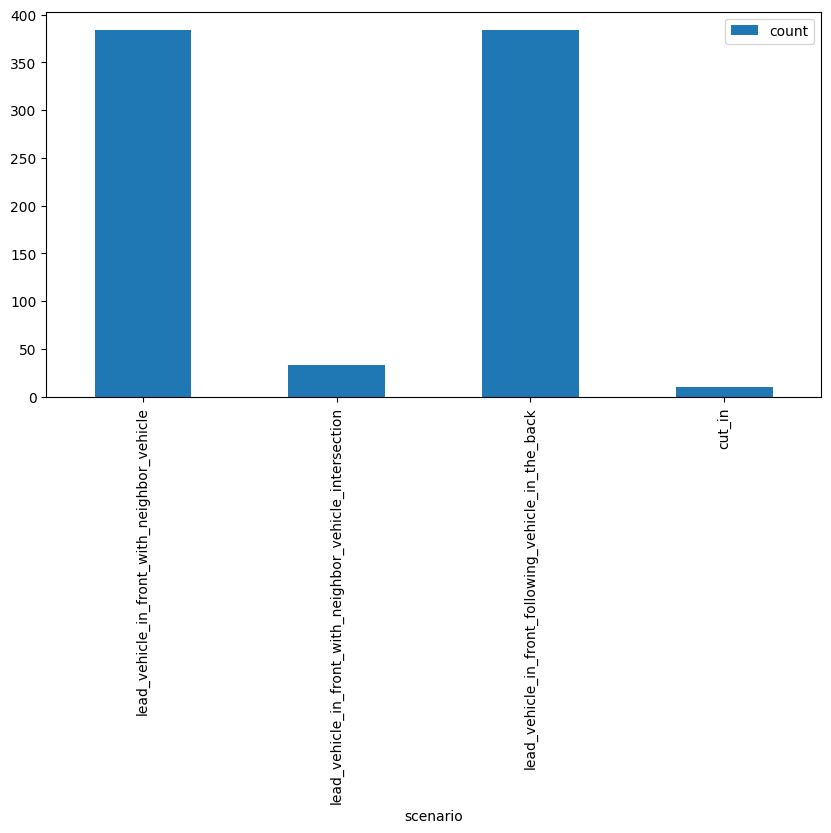

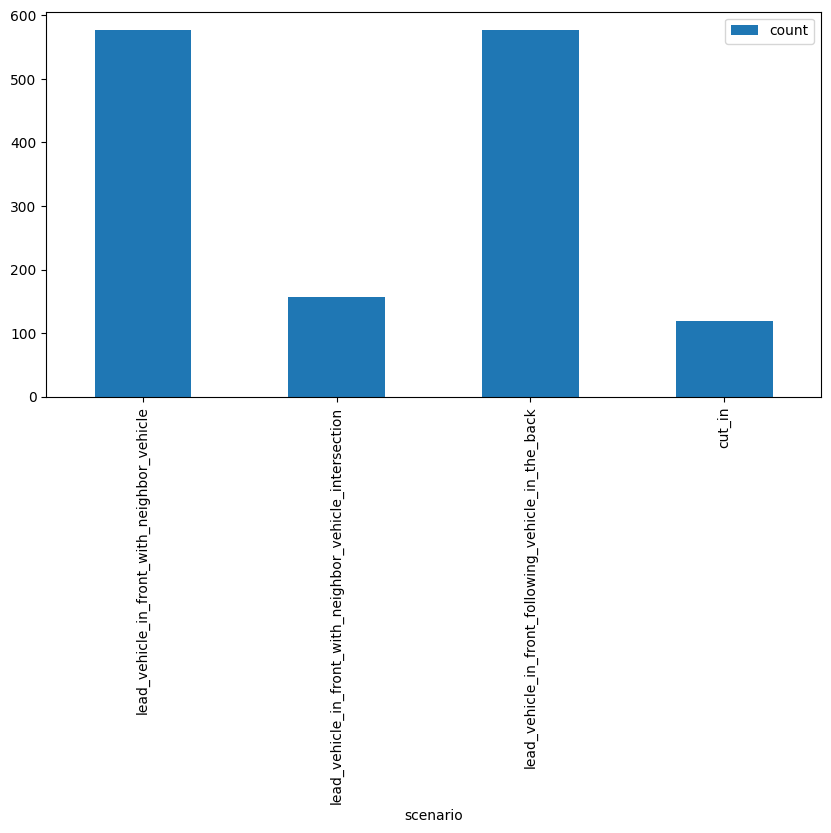

In [25]:
barchart_df = cov_data_df_carla[coverage_graphs.keys()].sum().reset_index().rename(columns={"index":"scenario", 0: "count"})
barchart_df.plot(kind="bar", x="scenario", y="count", figsize=(10, 5))
plt.savefig('article/plots/subgraph_isomorphism_carla_coverage_barchart.png', dpi=300, bbox_inches='tight')
plt.show()
barchart_df = cov_data_df_argo[coverage_graphs.keys()].sum().reset_index().rename(columns={"index":"scenario", 0: "count"})
barchart_df.plot(kind="bar", x="scenario", y="count", figsize=(10, 5))
plt.savefig('article/plots/subgraph_isomorphism_argo_coverage_barchart.png', dpi=300, bbox_inches='tight')
plt.show()

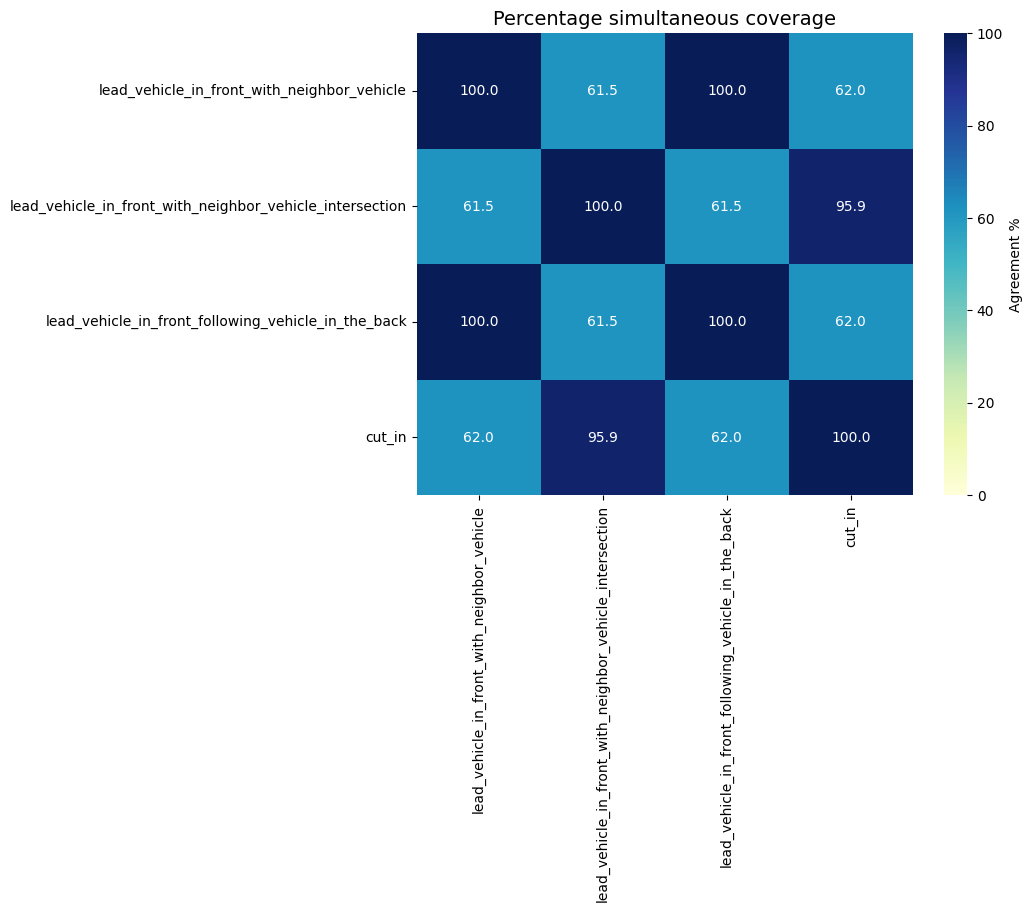

In [27]:
columns = list(coverage_graphs.keys())
# cov_data_df[coverage_graphs.keys()]
n_cols = len(columns)
agreement_matrix = np.zeros((n_cols, n_cols))

for i, col1 in enumerate(columns):
    for j, col2 in enumerate(columns):
        if i == j:
            # Diagonal: 100% agreement with itself
            agreement_matrix[i, j] = 100
        else:
            # Calculate percentage of rows where both columns agree
            agreement = (cov_data_df_carla[col1] == cov_data_df_carla[col2]).sum() / len(cov_data_df_carla) * 100
            agreement_matrix[i, j] = agreement

# Create DataFrame for the heatmap
agreement_df = pd.DataFrame(
    agreement_matrix,
    index=columns,
    columns=columns
)
agreement_df

# Create heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(agreement_df, 
            annot=True,  # Show percentages in cells
            fmt='.1f',   # Format to 1 decimal place
            cmap='YlGnBu',  # Color scheme
            vmin=0, 
            vmax=100,
            cbar_kws={'label': 'Agreement %'})
plt.title('Percentage simultaneous coverage', fontsize=14)
#plt.tight_layout()
plt.savefig('article/plots/subgraph_isomorphism_agreement_matrix_manual_scenarios_carla.png', dpi=300, bbox_inches='tight')
plt.show()

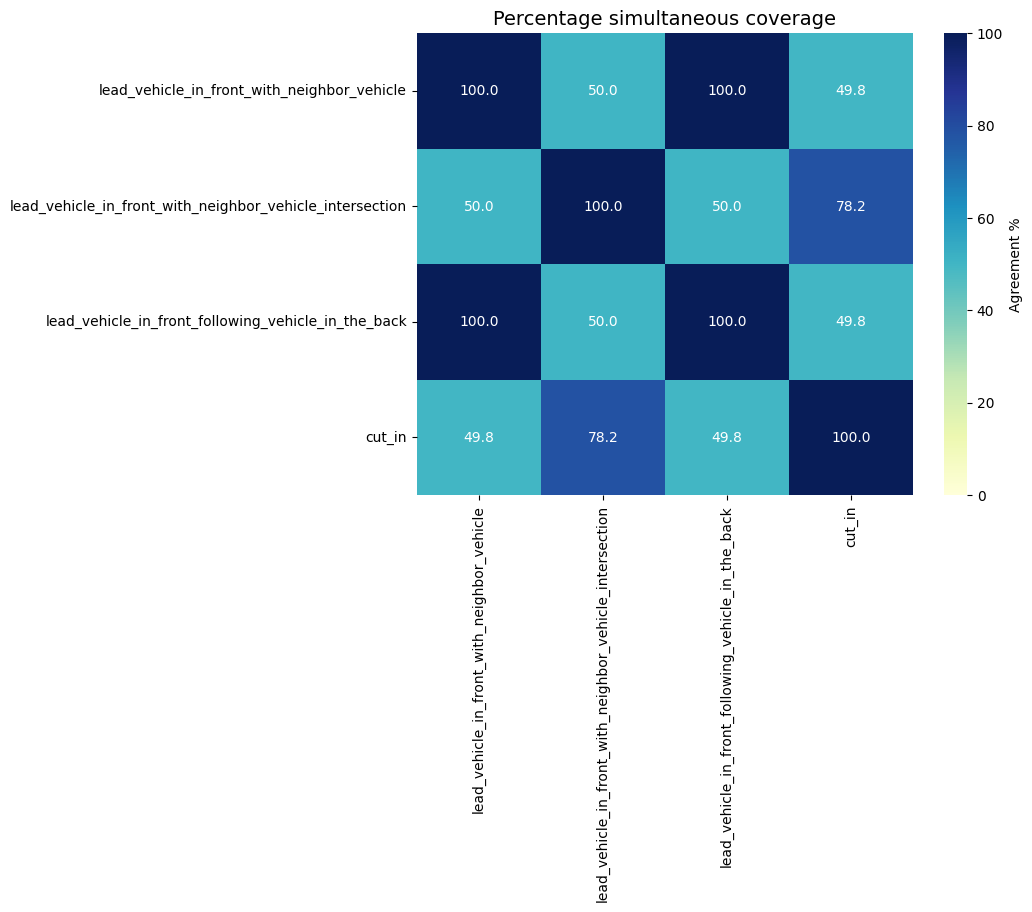

In [28]:
columns = list(coverage_graphs.keys())
# cov_data_df[coverage_graphs.keys()]
n_cols = len(columns)
agreement_matrix = np.zeros((n_cols, n_cols))

for i, col1 in enumerate(columns):
    for j, col2 in enumerate(columns):
        if i == j:
            # Diagonal: 100% agreement with itself
            agreement_matrix[i, j] = 100
        else:
            # Calculate percentage of rows where both columns agree
            agreement = (cov_data_df_argo[col1] == cov_data_df_argo[col2]).sum() / len(cov_data_df_argo) * 100
            agreement_matrix[i, j] = agreement

# Create DataFrame for the heatmap
agreement_df = pd.DataFrame(
    agreement_matrix,
    index=columns,
    columns=columns
)
agreement_df

# Create heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(agreement_df, 
            annot=True,  # Show percentages in cells
            fmt='.1f',   # Format to 1 decimal place
            cmap='YlGnBu',  # Color scheme
            vmin=0, 
            vmax=100,
            cbar_kws={'label': 'Agreement %'})
plt.title('Percentage simultaneous coverage', fontsize=14)
#plt.tight_layout()
plt.savefig('article/plots/subgraph_isomorphism_agreement_matrix_manual_scenarios_argo.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
os.getcwd()

In [29]:
groupby_df = cov_data_df_carla.groupby(list(cov_data_df_carla.columns[:(len(coverage_graphs.keys()))]), as_index=False).size()
groupby_df.columns = groupby_df.columns.str.replace('_', ' ')
latex_table = groupby_df.to_latex(index=False, caption='My Table', 
                          label='tab:mytable', position='htbp')

print(latex_table)

\begin{table}[htbp]
\caption{My Table}
\label{tab:mytable}
\begin{tabular}{rrrrr}
\toprule
lead vehicle in front with neighbor vehicle & lead vehicle in front with neighbor vehicle intersection & lead vehicle in front following vehicle in the back & cut in & size \\
\midrule
False & False & False & False & 596 \\
False & False & False & True & 3 \\
False & True & False & False & 17 \\
True & False & True & False & 362 \\
True & False & True & True & 6 \\
True & True & True & False & 15 \\
True & True & True & True & 1 \\
\bottomrule
\end{tabular}
\end{table}



In [30]:
coverage_graph_names = list(coverage_graphs.keys())

100%|██████████| 10/10 [00:00<00:00, 342.12it/s]


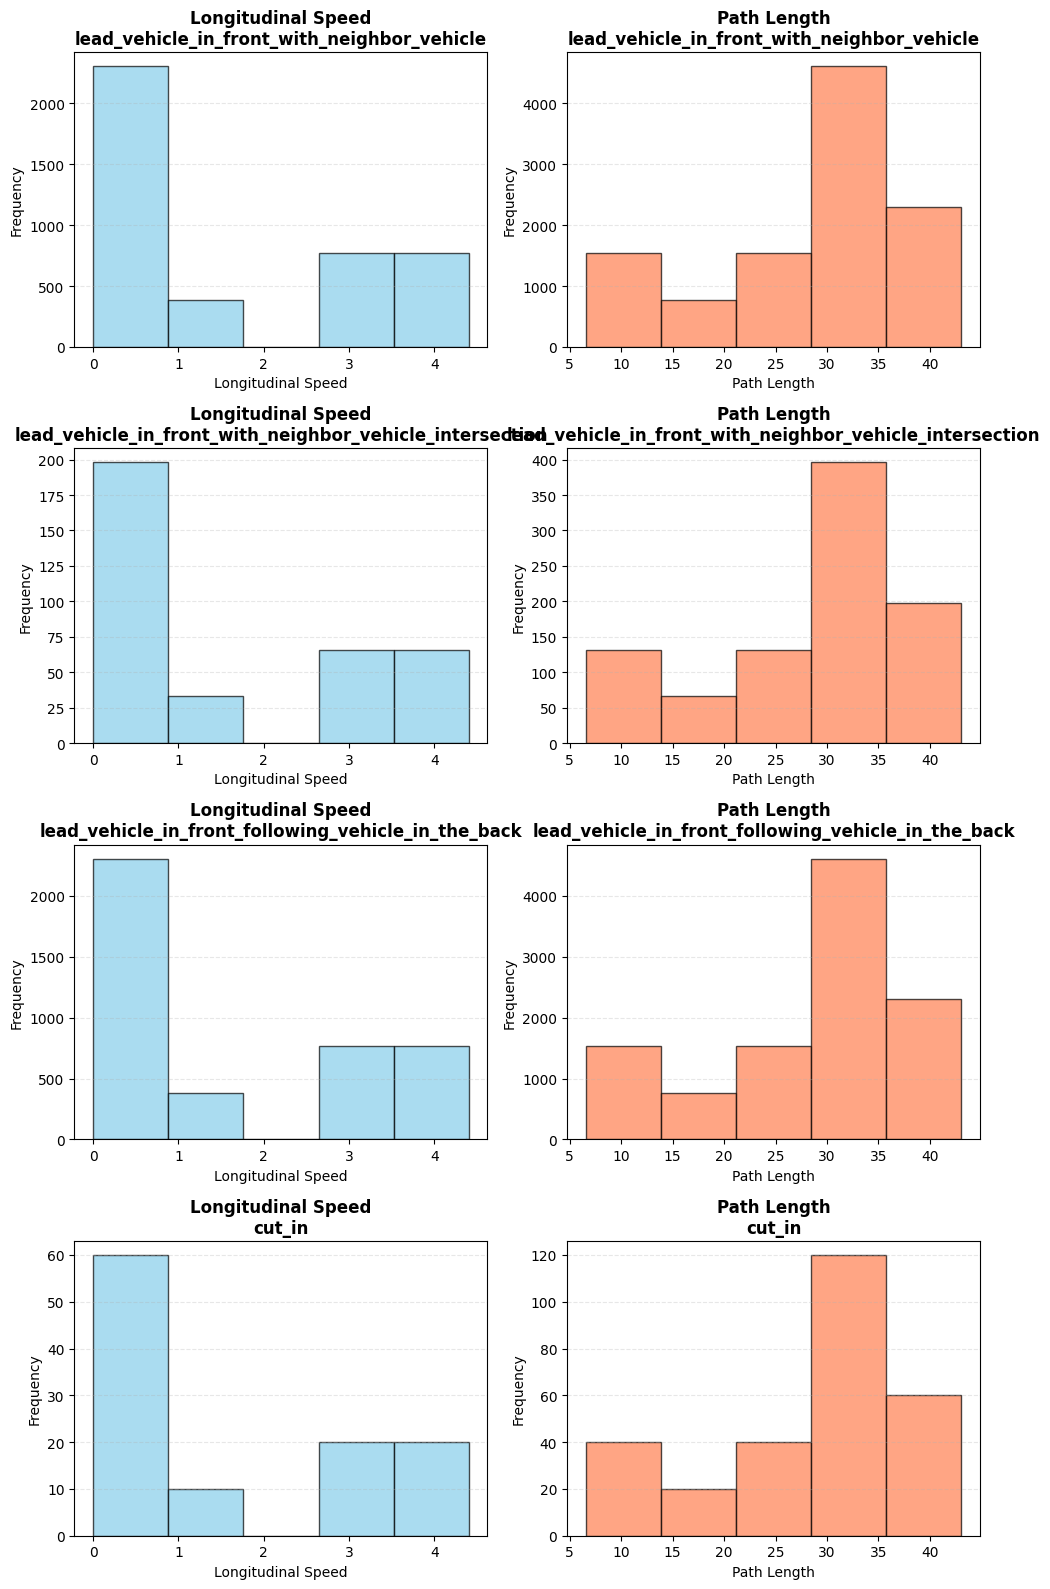

In [31]:
# Create figure with subplots: 2 rows, columns = number of coverage_graph_names
n_rows = len(coverage_graph_names)
fig, axes = plt.subplots(n_rows, 2, figsize=(10, 4*n_rows))

# If only one coverage_graph_name, axes won't be 2D, so fix that
#if n_cols == 1:
#    axes = axes.reshape(-1, 1)

for row_idx, coverage_graph_name in enumerate(coverage_graph_names):
    scn_graph_paths = cov_data_df_carla[cov_data_df_carla[coverage_graph_name]].path.to_list()
    
    # Get the speed and distances for all of the paths
    node_dfs = []
    edge_dfs = []
    for scn_graph_path in tqdm(scn_graph_paths):
        with open(scn_graph_path, "rb") as file:
            ag_nx = pickle.load(file)
        node_df, edge_df = make_node_edge_df(ag_nx)
        node_df["path"] = scn_graph_path
        edge_df["path"] = scn_graph_path
        node_dfs.append(node_df)
        edge_dfs.append(edge_df)
    
    node_df = pd.concat(node_dfs)
    edge_df = pd.concat(edge_dfs)
    
    # Plot 1: Longitudinal Speed (top row)
    node_df.lon_speed.plot(kind="hist", bins=5, ax=axes[row_idx, 0],
                           color='skyblue', edgecolor='black', alpha=0.7)
    axes[row_idx, 0].set_title(f'Longitudinal Speed\n{coverage_graph_name}', 
                                fontsize=12, fontweight='bold')
    axes[row_idx, 0].set_xlabel('Longitudinal Speed', fontsize=10)
    axes[row_idx, 0].set_ylabel('Frequency', fontsize=10)
    axes[row_idx, 0].grid(axis='y', alpha=0.3, linestyle='--')
    
    # Plot 2: Path Length (bottom row)
    edge_df.path_length.plot(kind="hist", bins=5, ax=axes[row_idx, 1],
                             color='coral', edgecolor='black', alpha=0.7)
    axes[row_idx, 1].set_title(f'Path Length\n{coverage_graph_name}', 
                                fontsize=12, fontweight='bold')
    axes[row_idx, 1].set_xlabel('Path Length', fontsize=10)
    axes[row_idx, 1].set_ylabel('Frequency', fontsize=10)
    axes[row_idx, 1].grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('article/plots/combined_distributions_plots_speed_distance_carla.png', dpi=300, bbox_inches='tight')
plt.show()

100%|██████████| 119/119 [00:00<00:00, 271.85it/s]


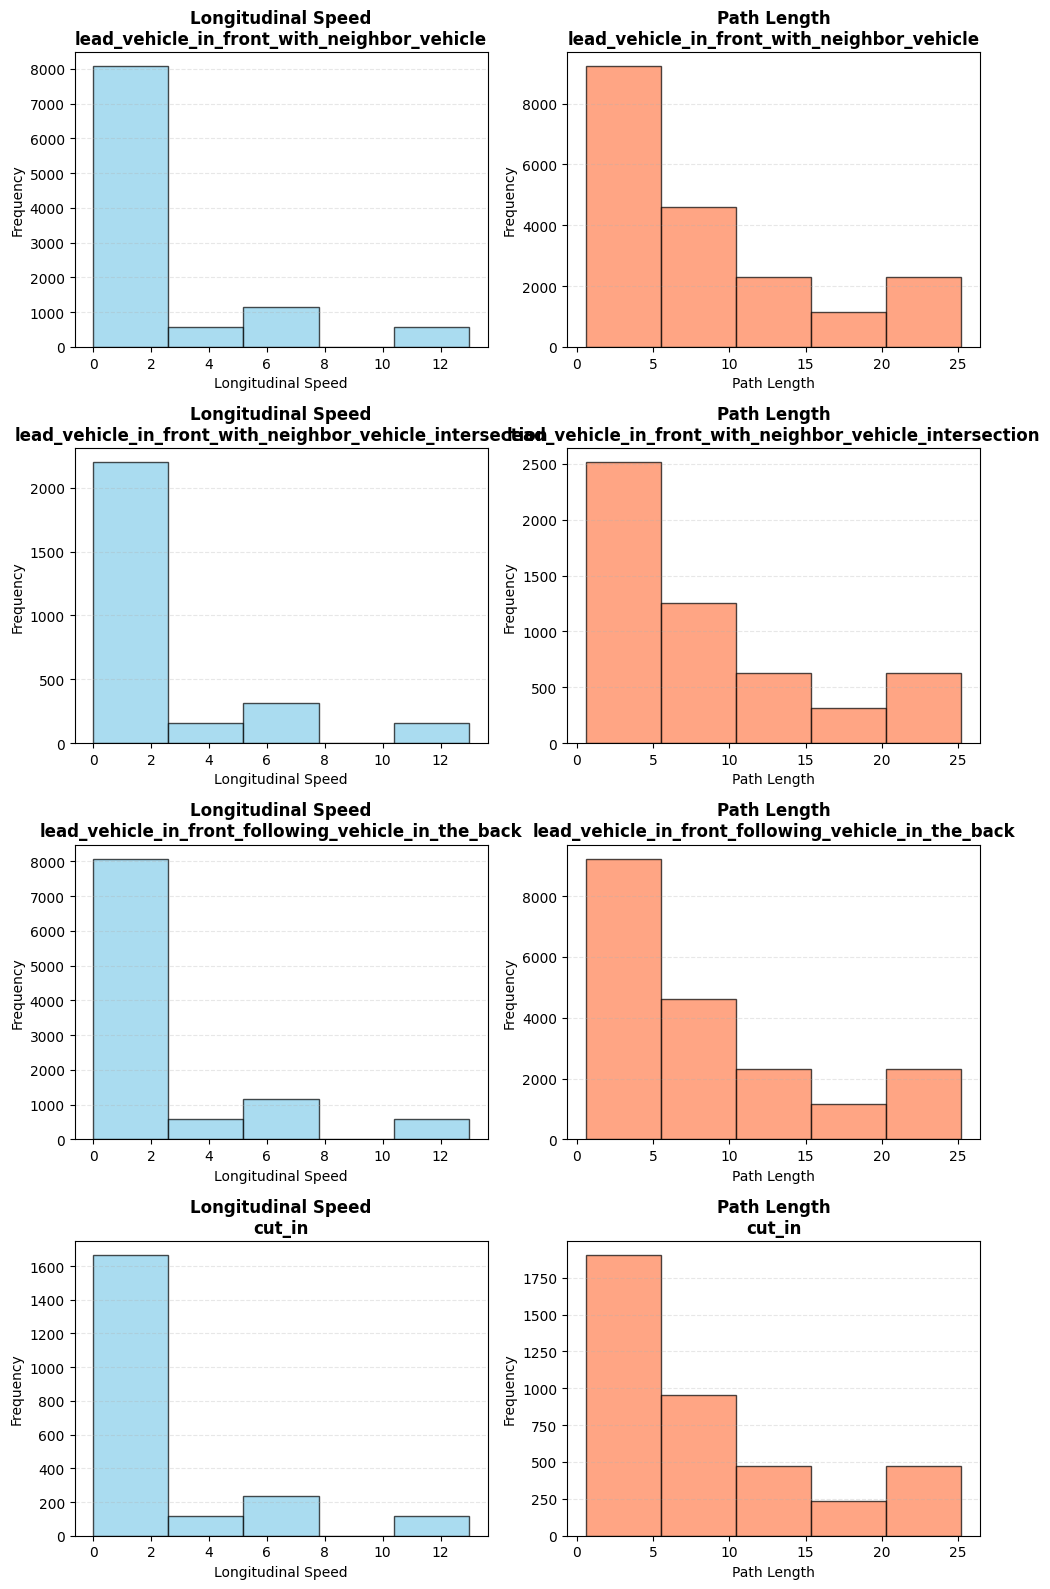

In [ ]:
# Create figure with subplots: 2 rows, columns = number of coverage_graph_names
n_rows = len(coverage_graph_names)
fig, axes = plt.subplots(n_rows, 2, figsize=(10, 4*n_rows))

# If only one coverage_graph_name, axes won't be 2D, so fix that
#if n_cols == 1:
#    axes = axes.reshape(-1, 1)

for row_idx, coverage_graph_name in enumerate(coverage_graph_names):
    scn_graph_paths = cov_data_df_argo[cov_data_df_argo[coverage_graph_name]].path.to_list()
    
    # Get the speed and distances for all of the paths
    node_dfs = []
    edge_dfs = []
    for scn_graph_path in tqdm(scn_graph_paths):
        with open(scn_graph_path, "rb") as file:
            ag_nx = pickle.load(file)
        node_df, edge_df = make_node_edge_df(ag_nx)
        node_df["path"] = scn_graph_path
        edge_df["path"] = scn_graph_path
        node_dfs.append(node_df)
        edge_dfs.append(edge_df)
    
    node_df = pd.concat(node_dfs)
    edge_df = pd.concat(edge_dfs)
    
    # Plot 1: Longitudinal Speed (top row)
    node_df.lon_speed.plot(kind="hist", bins=5, ax=axes[row_idx, 0],
                           color='skyblue', edgecolor='black', alpha=0.7)
    axes[row_idx, 0].set_title(f'Longitudinal Speed\n{coverage_graph_name}', 
                                fontsize=12, fontweight='bold')
    axes[row_idx, 0].set_xlabel('Longitudinal Speed', fontsize=10)
    axes[row_idx, 0].set_ylabel('Frequency', fontsize=10)
    axes[row_idx, 0].grid(axis='y', alpha=0.3, linestyle='--')
    
    # Plot 2: Path Length (bottom row)
    edge_df.path_length.plot(kind="hist", bins=5, ax=axes[row_idx, 1],
                             color='coral', edgecolor='black', alpha=0.7)
    axes[row_idx, 1].set_title(f'Path Length\n{coverage_graph_name}', 
                                fontsize=12, fontweight='bold')
    axes[row_idx, 1].set_xlabel('Path Length', fontsize=10)
    axes[row_idx, 1].set_ylabel('Frequency', fontsize=10)
    axes[row_idx, 1].grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('article/plots/combined_distributions_plots_speed_distance_argo.png', dpi=300, bbox_inches='tight')
plt.show()

100%|██████████| 384/384 [00:00<00:00, 389.09it/s]


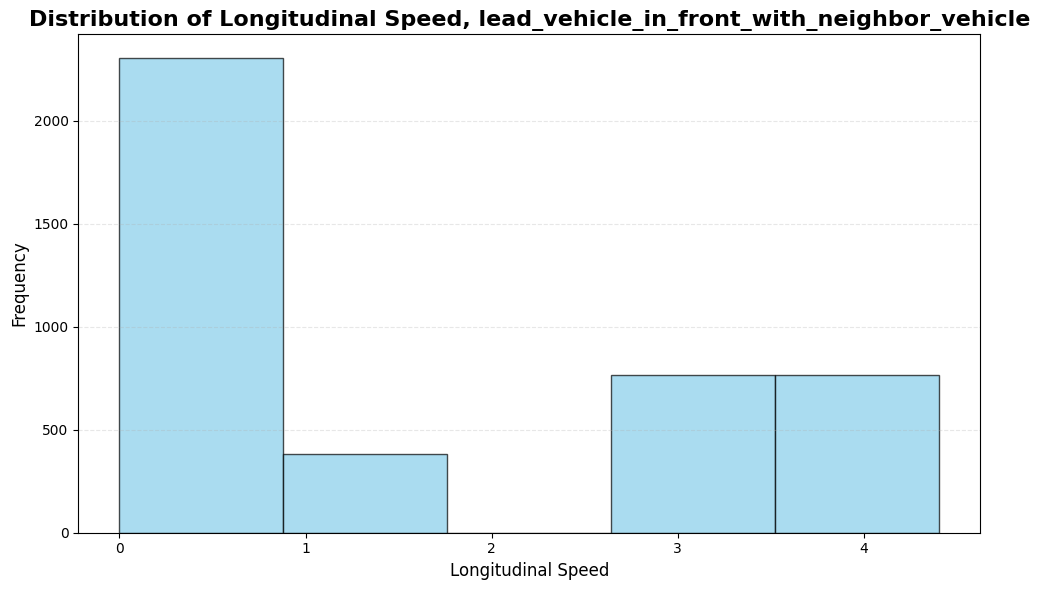

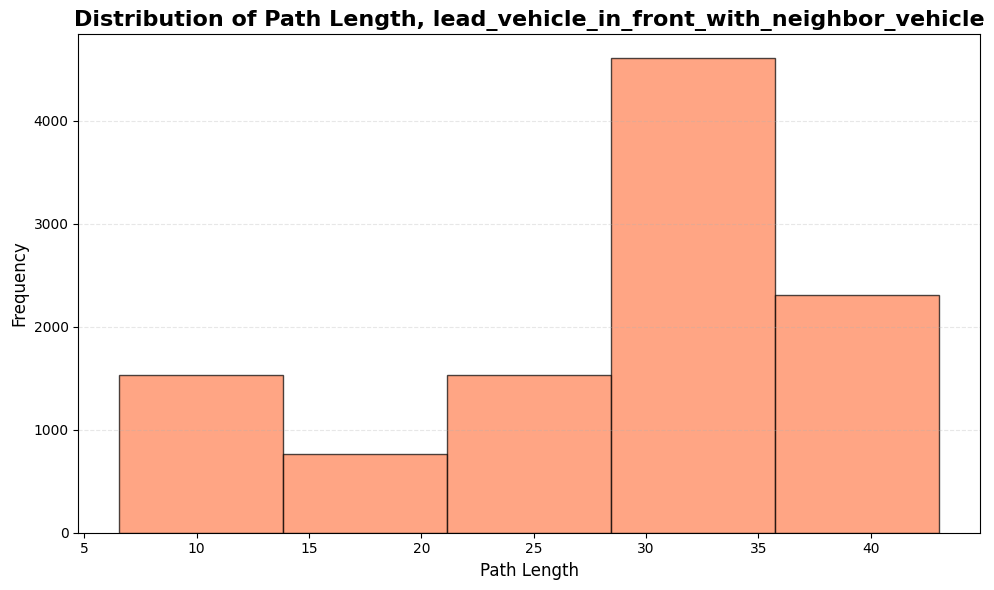

100%|██████████| 33/33 [00:00<00:00, 387.37it/s]


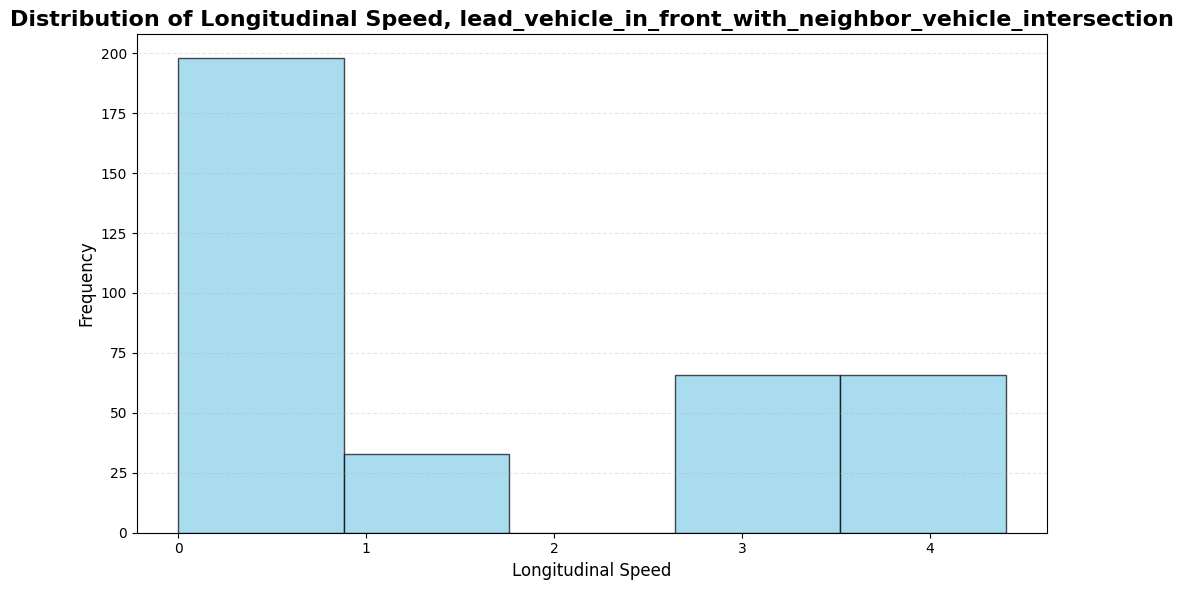

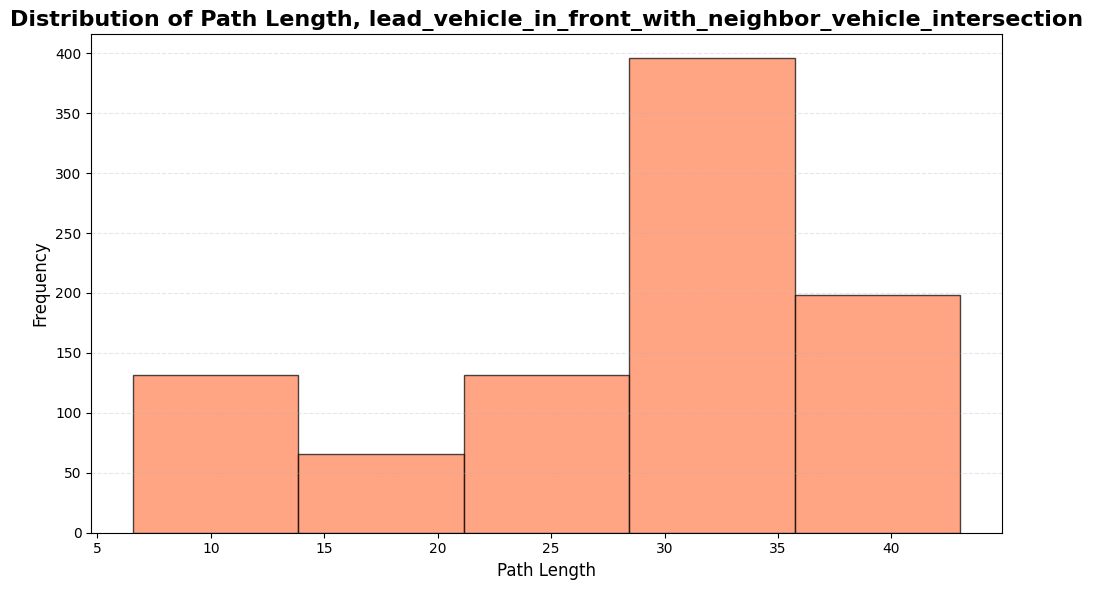

100%|██████████| 384/384 [00:01<00:00, 339.94it/s]


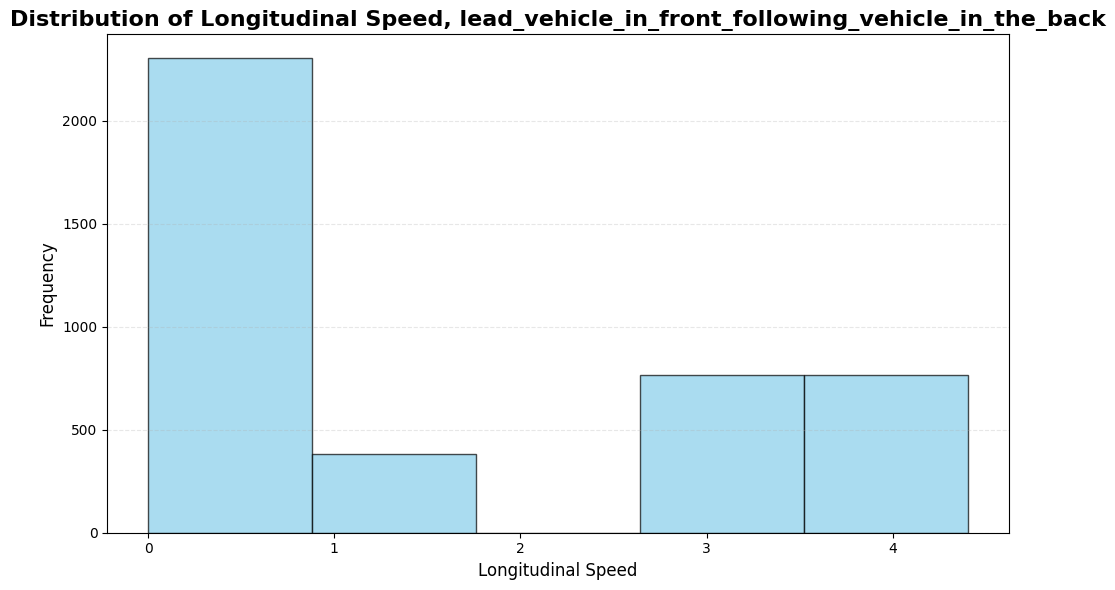

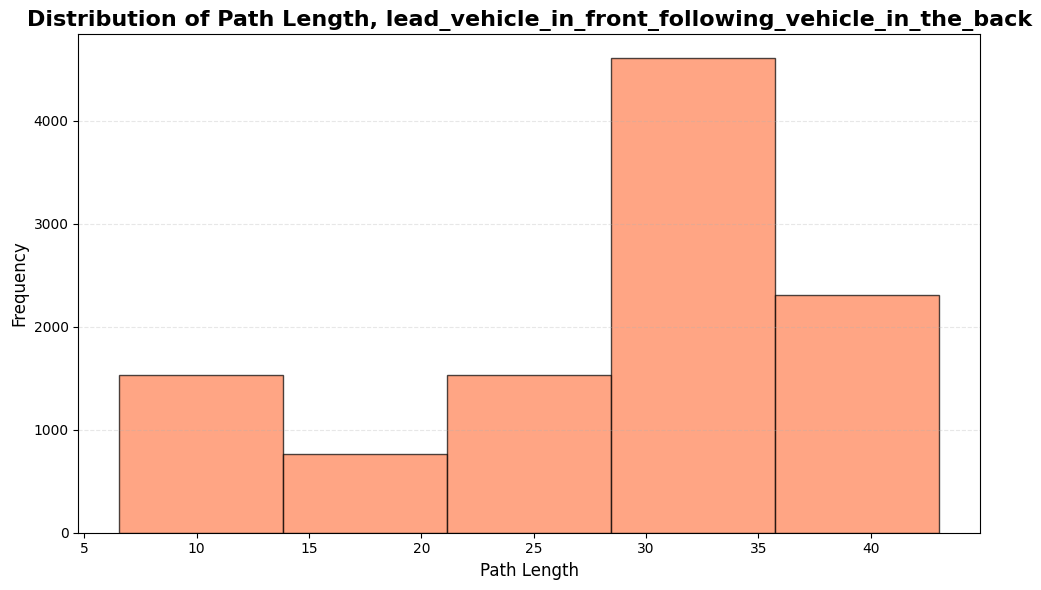

100%|██████████| 10/10 [00:00<00:00, 345.25it/s]


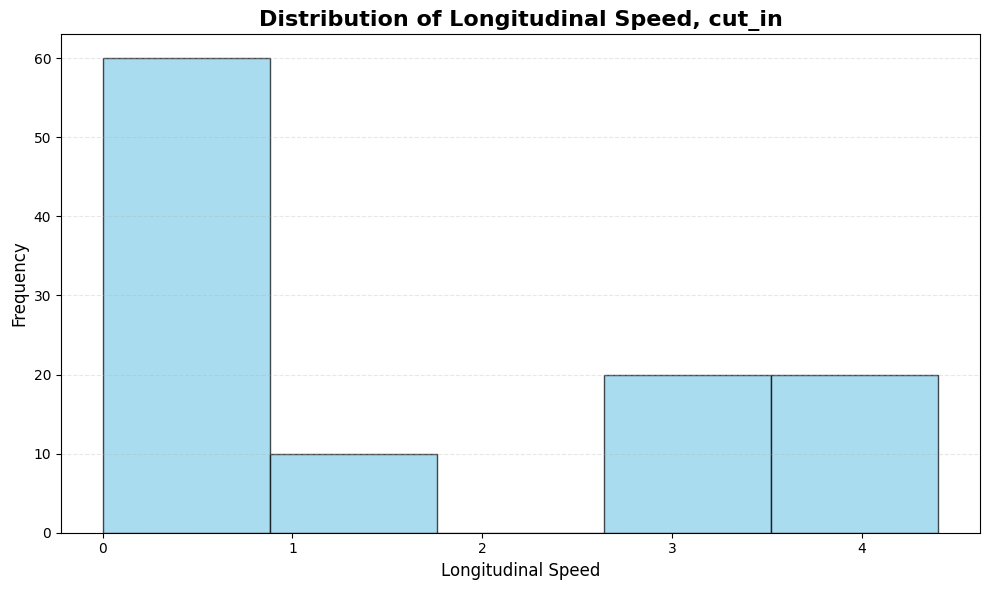

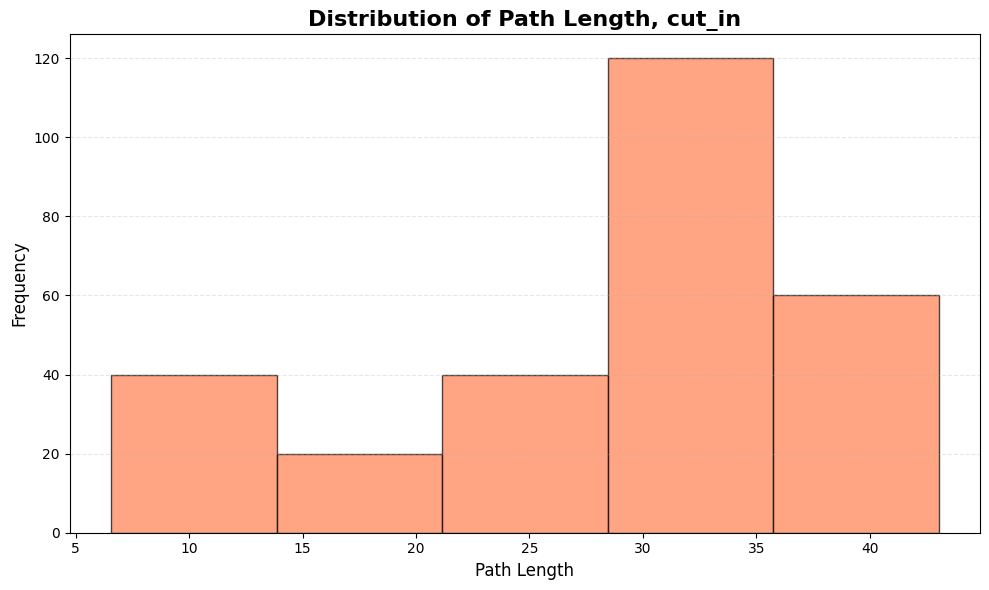

In [34]:
for coverage_graph_name in coverage_graph_names:
    scn_graph_paths = cov_data_df_carla[cov_data_df_carla[coverage_graph_name]].path.to_list()
    # get some the speed and distances for all of the
    node_dfs = []
    edge_dfs = []
    for scn_graph_path in tqdm(scn_graph_paths):
        with open(scn_graph_path, "rb") as file:
            ag_nx = pickle.load(file)
        node_df, edge_df = make_node_edge_df(ag_nx)
        node_df["path"] = scn_graph_path
        edge_df["path"] = scn_graph_path
        node_dfs.append(node_df)
        edge_dfs.append(edge_df)
    node_df = pd.concat(node_dfs)
    edge_df = pd.concat(edge_dfs)
    # Plot 1: Longitudinal Speed
    plt.figure(figsize=(10, 6))
    node_df.lon_speed.plot(kind="hist", bins=5, color='skyblue', edgecolor='black', alpha=0.7)
    plt.title(f'Distribution of Longitudinal Speed, {coverage_graph_name}', fontsize=16, fontweight='bold')
    plt.xlabel('Longitudinal Speed', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.grid(axis='y', alpha=0.3, linestyle='--')
    plt.tight_layout()
    #plt.savefig('lon_speed_hist.png', dpi=300, bbox_inches='tight')
    plt.show()
    # Plot 2: Path Length
    plt.figure(figsize=(10, 6))
    edge_df.path_length.plot(kind="hist", bins=5, color='coral', edgecolor='black', alpha=0.7)
    plt.title(f'Distribution of Path Length, {coverage_graph_name}', fontsize=16, fontweight='bold')
    plt.xlabel('Path Length', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.grid(axis='y', alpha=0.3, linestyle='--')
    plt.tight_layout()
    # plt.savefig('path_length_hist.png', dpi=300, bbox_inches='tight')
    plt.show()



In [ ]:
node_df

In [ ]:
#import matplotlib.pyplot as plt



# Notebook junkyard

